# <div align="center"><b> ПРОЕКТ ДЛЯ "ВИКИШОП" </b></div> 

**Цель:** построить модель, выявляющую токсичные коммментарии к товарам интернет-магазина "Викишоп".

**Требования к качеству модели:** качество модели должно оцениваться с помощью метрики f1. Значение f1 должно быть не менее 0.75.

# 1. Подготовка данных

## 1.1 Загрузка и обзор данных

In [1]:
# Install spaCy (run in terminal/prompt)
import sys
!{sys.executable} -m pip install spacy
# Download spaCy's  'en' Model
!{sys.executable} -m spacy download en

  Using cached spacy-3.4.1-cp39-cp39-win_amd64.whl (11.8 MB)
  Using cached typer-0.4.2-py3-none-any.whl (27 kB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached wasabi-0.10.1-py3-none-any.whl (26 kB)
  Using cached cymem-2.0.6-cp39-cp39-win_amd64.whl (36 kB)
  Using cached spacy_legacy-3.0.10-py2.py3-none-any.whl (21 kB)
  Using cached preshed-3.0.7-cp39-cp39-win_amd64.whl (96 kB)
  Using cached pathy-0.6.2-py3-none-any.whl (42 kB)
  Using cached murmurhash-1.0.8-cp39-cp39-win_amd64.whl (18 kB)
  Using cached catalogue-2.0.8-py3-none-any.whl (17 kB)
  Using cached spacy_loggers-1.0.3-py3-none-any.whl (9.3 kB)
  Using cached srsly-2.4.4-cp39-cp39-win_amd64.whl (450 kB)
  Using cached smart_open-5.2.1-py3-none-any.whl (58 kB)
  Using cached confection-0.0.3-py3-none-any.whl (32 kB)
  Using cached blis-0.7.8-cp39-cp39-win_amd64.whl (6.6 MB)
[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.


In [87]:
#импортируем библиотеки
import pandas as pd
import spacy
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

In [3]:
#сформируем датафрейм
try:
    #берем данные с локального компьютера
    df = pd.read_csv(r'C:\Users\vizum\Desktop\yandex_practicum\project_13\datasets\toxic_comments.csv', index_col=0)
except:
    #берем данные с хранилища Яндекс.Практикума
    df=pd.read_csv('/datasets/toxic_comments.csv')
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0


In [4]:
#посмотрим общую информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Пропусков нет, с типами данных тоже все в порядке. Посмотрим на распределение классов.

In [5]:
#посмотрим, как распределены классы
df['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

Соотношение классов 9:1 - жуткий дисбаланс =(

## 1.2 Подготовка данных к обучению

Выполним лемматизацию данных:

In [6]:
#инициируем лемматизатор spacy
nlp = spacy.load('en_core_web_sm')

In [7]:
#напишем функцию для лемматизации
def lemmatize(row):
    return(" ".join([token.lemma_ for token in nlp(row)]))

In [8]:
#проверим функцию лемматизации:
print(15*'=', 'Исходный текст', 15*'=')
print(df.loc[2, 'text'])
print()
print(15*'=', 'Лемматизированный текст', 15*'=')
print(lemmatize(df.loc[2, 'text']))

=============== Исходный текст ===============
Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.

=============== Лемматизированный текст ===============
hey man , I be really not try to edit war . it be just that this guy be constantly remove relevant information and talk to I through edit instead of my talk page . he seem to care more about the formatting than the actual info .


Выполним очистку текста от лишних символов.

In [9]:
#напишем функцию очистки текста от лишних символов
def clear_text(row):
    re_text = re.sub(r'[^a-zA-Z]', ' ', row)
    re_text = ' '.join(re_text.split())
    return(re_text)

In [10]:
#проверим функцию очистки:
print(15*'=', 'Исходный текст', 15*'=')
print(df.loc[2, 'text'])
print()
print(15*'=', 'Очищенный текст', 15*'=')
print(clear_text(df.loc[2, 'text']))

=============== Исходный текст ===============
Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.

=============== Очищенный текст ===============
Hey man I m really not trying to edit war It s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info


In [11]:
#очистим данные от лишних символов
df['text'] = df['text'].apply(clear_text)
df

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D aww He matches this background colour I m se...,0
2,Hey man I m really not trying to edit war It s...,0
3,More I can t make any real suggestions on impr...,0
4,You sir are my hero Any chance you remember wh...,0
...,...,...
159446,And for the second time of asking when your vi...,0
159447,You should be ashamed of yourself That is a ho...,0
159448,Spitzer Umm theres no actual article for prost...,0
159449,And it looks like it was actually you who put ...,0


In [12]:
%%time

#лемматизируем текст
df['text'] = df['text'].apply(lemmatize)
df

Wall time: 31min 57s


,text,toxic
0,Explanation why the edit make under my usernam...,0
1,D aww he match this background colour I m seem...,0
2,hey man I m really not try to edit war it s ju...,0
3,More I can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0
...,...,...
159446,and for the second time of ask when your view ...,0
159447,you should be ashamed of yourself that be a ho...,0
159448,Spitzer Umm there s no actual article for pros...,0
159449,and it look like it be actually you who put on...,0


Приведем все символы к нижнему регистру.

In [13]:
df['text'] = df['text'].str.lower()
df

,text,toxic
0,explanation why the edit make under my usernam...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0
...,...,...
159446,and for the second time of ask when your view ...,0
159447,you should be ashamed of yourself that be a ho...,0
159448,spitzer umm there s no actual article for pros...,0
159449,and it look like it be actually you who put on...,0


Разделим данные на обучающую и тестовую выборки в соотношении 3:1. 

In [14]:
train, test = train_test_split(df, test_size=0.25, stratify = df['toxic'], random_state=12345)

In [15]:
#проверим результат разделения
print(15*'=', 'Размер тренировочной выборки', 15*'=')
print(train.shape)
print()
print(15*'=', 'Размер тестовой выборки', 15*'=')
print(test.shape)

=============== Размер тренировочной выборки ===============
(119469, 2)

=============== Размер тестовой выборки ===============
(39823, 2)


Выделим из обучающей и тестовой выборок целевой признак и корпусы текстов.

In [16]:
#выделим корпусы текстов
corp_train = train['text'].values
corp_test = test['text'].values

In [17]:
#проверим результат выделения корпусов
print(15*'=', 'Размер тренировочного корпуса', 15*'=')
print(corp_train.shape)
print()
print(15*'=', 'Размер тестового корпуса', 15*'=')
print(corp_test.shape)

=============== Размер тренировочного корпуса ===============
(119469,)

=============== Размер тестового корпуса ===============
(39823,)


In [18]:
#выделим целевые признаки
target_train = train['toxic']
target_test = test['toxic']

In [19]:
print(15*'=', 'Размер тренировочного целевого признака', 15*'=')
print(target_train.shape)
print()
print(15*'=', 'Размер тестового целевого признака', 15*'=')
print(target_test.shape)

=============== Размер тренировочного целевого признака ===============
(119469,)

=============== Размер тестового целевого признака ===============
(39823,)


Рассчитаем TF-IDF для корпусов текстов.

In [20]:
#загрузим стоп-слова
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vizum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
#выполним расчет tf-idf
#tf_idf = TfidfVectorizer(stop_words=stopwords)
#corp_train_tdidf = tf_idf.fit_transform(corp_train)
#corp_test_tdidf = tf_idf.transform(corp_test)

In [81]:
#выполним расчет tf-idf
tf_idf = TfidfVectorizer(stop_words=stopwords)
corp_train_tdidf = tf_idf.fit_transform(corp_train)
corp_test_tdidf = tf_idf.transform(corp_test)

In [82]:
print(15*'=', 'Размер матрицы векторов TF-IDF для тренировочного корпуса', 15*'=')
print(corp_train_tdidf.shape)
print()
print(15*'=', 'Размер матрицы векторов TF-IDF для тестового корпуса', 15*'=')
print(corp_test_tdidf.shape)

=============== Размер матрицы векторов TF-IDF для тренировочного корпуса ===============
(119469, 132423)

=============== Размер матрицы векторов TF-IDF для тестового корпуса ===============
(39823, 132423)


Напоследок посмотрим, насколько хорошо разделены классы (используем тренировочные выборки).

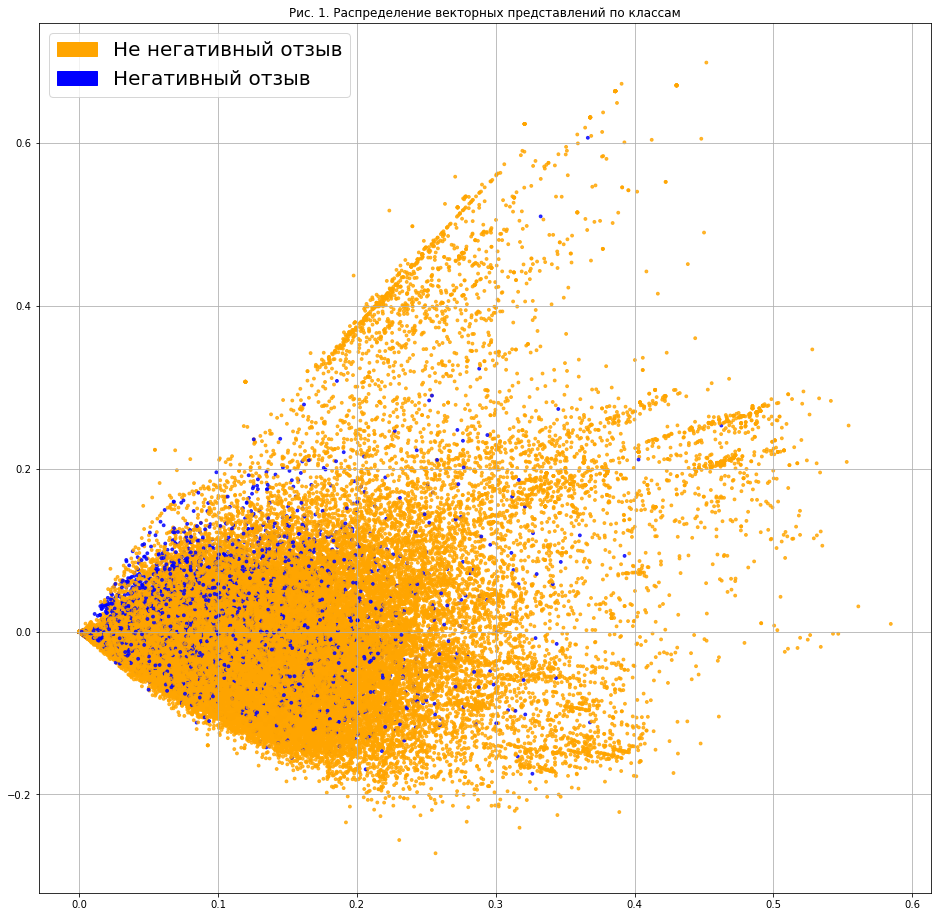

In [88]:
def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Не негативный отзыв')
            green_patch = mpatches.Patch(color='blue', label='Негативный отзыв')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})


fig = plt.figure(figsize=(16, 16))  
plot_LSA(corp_train_tdidf, target_train)
plt.grid()
plt.title('Рис. 1. Распределение векторных представлений по классам')
plt.show()

Разделение классов не выявляется, что может быть также обусловленно выбранным способом визуализации или эффектом сокращения размерности для построения графика.

# 2. Обучим модели

В текущем разделе обучим модели на основе трех алгоритмов: 
   - логистической регрессии;
   - дерева решений;
   - градиентного бустинга (библиотека LightGBM).
   
Качество моделей оценим на кросс-валидации с помощью метрики **f1**. Целевое значение метрики - **не менее 0.75**.

## 2.1 Модель логистической регрессии

In [ ]:
#%%time
#model_lr = LogisticRegression(random_state=12345, class_weight='balanced', max_iter=150)

#получаем список RMSE моделей на кроссвалидации
#scores_lr = cross_val_score(model_lr, corp_train_tdidf, target_train, scoring='f1')

In [26]:
%%time
#model_lr = LogisticRegression(random_state=12345, class_weight='balanced', max_iter=150)

#получаем список RMSE моделей на кроссвалидации
scores_lr = cross_val_score(Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)), ('model_lr', LogisticRegression(random_state=12345, class_weight='balanced', max_iter=150))]), corp_train, target_train, scoring='f1')

Wall time: 46.7 s


In [27]:
#выведем оценки качества модели
print('Все оценки модели на кросс-валидации', scores_lr)
print('Средняя оценка модели на кроссвалидации:', pd.Series(scores_lr).mean())

Все оценки модели на кросс-валидации [0.751673   0.74179589 0.75405061 0.75269603 0.74118943]
Средняя оценка модели на кроссвалидации: 0.7482809913332032


## 2.2 Модель на основе дерева решений

In [42]:
#сформируем список с набором гиперпараметров
dt_params = {'model_dt__max_depth':[3, 4, 5, 6, 7, 8, 9, 10], 'model_dt__min_samples_split':[2, 3, 4, 5, 6, 7, 8, 9, 10]}

In [43]:
%%time

#обучим модель дерева решений, оценку качества выполним на кроссвалидации
GS_dt = GridSearchCV(Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)),('model_dt', DecisionTreeClassifier(random_state=12345, class_weight='balanced'))]), 
                     param_grid=dt_params, scoring = 'f1', verbose=1)
GS_dt.fit(corp_train, target_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Wall time: 46min 44s


GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
                            

In [45]:
print('Наилучшие параметры модели на основе алгоритма дерева решений')
GS_dt.best_params_

Наилучшие параметры модели на основе алгоритма дерева решений


{'model_dt__max_depth': 10, 'model_dt__min_samples_split': 10}

In [46]:
print('Наилучшее значение f1 для модели на основе алгоритма дерева решений')
GS_dt.best_score_

Наилучшее значение f1 для модели на основе алгоритма дерева решений


0.5669066966703771

## 2.3 Ансамблевая модель LightGBM

In [47]:
#зададим сетку гиперпараметров
lgbm_params = {'model_lgbm__n_estimators':[10, 20, 30, 40, 50], 'model_lgbm__max_depth':[1, 2, 3, 4, 5, 6, 7], 'model_lgbm__reg_lambda':[0, 0.3, 0.7]}

In [48]:
%%time

#обучим модель
GS_lgbm = GridSearchCV(Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)), ('model_lgbm', LGBMClassifier(class_weight='balanced', random_state=12345))]), param_grid=lgbm_params, scoring = 'f1', verbose=1)
GS_lgbm.fit(corp_train, target_train)

Fitting 5 folds for each of 105 candidates, totalling 525 fits
Wall time: 1h 34min 17s


GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
                            

In [49]:
print('Наилучшие параметры модели LightGBM')
GS_lgbm.best_params_

Наилучшие параметры модели LightGBM


{'model_lgbm__max_depth': 7,
 'model_lgbm__n_estimators': 50,
 'model_lgbm__reg_lambda': 0.7}

In [50]:
print('Наилучшее значение f1 для модели LightGBM')
GS_lgbm.best_score_

Наилучшее значение f1 для модели LightGBM


0.7040368391493276

## 2.4 Анализ результатов

Соберем показания метрик моделей в таблицу для наглядного представления.

In [51]:
pivot=pd.DataFrame({'Модель':['model_lr', 'model_dt', 'model_lgbm'], 
                   'Алгоритм':['Логистическая регрессия', 'Дерево решений', 'Градиентый бустинг'],
                   'Значение f1':[pd.Series(scores_lr).mean(), GS_dt.best_score_, GS_lgbm.best_score_],
                   'Гиперпараметры':['{max_iter=150}', GS_dt.best_params_, GS_lgbm.best_params_]})
pivot.sort_values(by='Значение f1', ascending=False)

,Модель,Алгоритм,Значение f1,Гиперпараметры
0,model_lr,Логистическая регрессия,0.748281,{max_iter=150}
2,model_lgbm,Градиентый бустинг,0.704037,"{'model_lgbm__max_depth': 7, 'model_lgbm__n_es..."
1,model_dt,Дерево решений,0.566907,"{'model_dt__max_depth': 10, 'model_dt__min_sam..."


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Отлично, что есть табличка результатов для сравнения.</font>

Наилучшую точность из трех обученных моделей показала модель на основе алгоритма логистической регрессии **f1=0.75**.
Полученное значение находится на нижней границе допуска (целевое значение метрики f1 должно быть не менее 0.75), однако является приемлемым. Выберем модель **model_lr** в качестве наилучшей, обучим ее на всей тренировочной выборке и рассчитаем точность предсказания на тестовой выборке.

# 3. Проверка модели на тестовой выборке

In [97]:
#переобучим модель на тренировочной выборке
model_lr.fit(corp_train_tdidf, target_train)

LogisticRegression(class_weight='balanced', max_iter=150, random_state=12345)

In [98]:
#сделаем предсказание
predictions = model_lr.predict(corp_test_tdidf)

In [99]:
#выполним оценку точности предсказания
final_f1 = f1_score(target_test, predictions)
final_f1

0.756433923335867

Значение метрики f1 на тестовой выборке составляет **f1=0.76**, что чуть лучше оценки модели на кросс-валидации и удовлетворяет требованиям к качеству модели. Посмотрим на матрицу ошибок предсказания.

In [52]:
print(confusion_matrix(target_test, predictions))

[[34097  1680]
 [  563  3483]]


1675 негативных отзывов остались нераспознаны. Посчитаем, какой это процент всех негативных отзывов в тестовой выборке:

In [53]:
1680/sum(target_test==1)*100

41.522491349480966

42% негативных отзывов остались незамеченными :( модель явно надо дорабатывать.

Посмотрим, какие из признаков оказались для модели наиболее весомыми.

In [54]:
#запишем функцию для выделения наиболее и наименее весомых слов для модели
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'Most_important':tops,
            'Least_important':bottom
        }
    return classes

In [55]:
importance_tfidf = get_most_important_features(tf_idf, model_lr, 10)
importance_tfidf

{0: {'Most_important': [(10.995096952007593, 'asshole'),
   (11.002891571450133, 'bitch'),
   (12.155859536905508, 'bullshit'),
   (12.3526699893434, 'suck'),
   (12.385870378947414, 'ass'),
   (13.784890897382628, 'fucking'),
   (14.69532320184898, 'stupid'),
   (15.035122750337036, 'idiot'),
   (15.128178049541825, 'shit'),
   (21.135277730352982, 'fuck')],
  'Least_important': [(-2.599700993625603, 'lead'),
   (-2.64756687945806, 'title'),
   (-2.791348127600735, 'source'),
   (-2.952880898634458, 'utc'),
   (-3.3430863922593863, 'review'),
   (-3.384587996837338, 'continue'),
   (-3.452641315430015, 'mention'),
   (-3.670934395845728, 'please'),
   (-4.230711545974699, 'redirect'),
   (-4.892749707568182, 'thank')]}}

Представим наиболее и наименее весомые для модели слова в табличном виде.

In [56]:
features_importance = {'Most_important_words':[], 'Most_importance':[], 'Least_important_words':[], 'Least_importance':[]}
for i in range(0, 10):
    features_importance['Most_important_words'].append(importance_tfidf[0]['Most_important'][i][1])
    features_importance['Most_importance'].append(importance_tfidf[0]['Most_important'][i][0])
    features_importance['Least_important_words'].append(importance_tfidf[0]['Least_important'][i][1])
    features_importance['Least_importance'].append(importance_tfidf[0]['Least_important'][i][0])
    
features_importance = pd.DataFrame(features_importance)
features_importance

,Most_important_words,Most_importance,Least_important_words,Least_importance
0,asshole,10.995097,lead,-2.599701
1,bitch,11.002892,title,-2.647567
2,bullshit,12.155860,source,-2.791348
3,suck,12.352670,utc,-2.952881
4,ass,12.385870,review,-3.343086
5,fucking,13.784891,continue,-3.384588
6,stupid,14.695323,mention,-3.452641
7,idiot,15.035123,please,-3.670934
8,shit,15.128178,redirect,-4.230712
9,fuck,21.135278,thank,-4.892750


Список десяти наиболее важных и наименее важных слов для выделения негативных комментариев выглядит адекватным.

# 4. Общий вывод

В рамках создания модели по выявлению токсичных комментариев было выполнено:
- выполнена векторизация данных. Данные очищены от стоп-слов и лишних символов;
- обучено три модели на основе трех алгоритмов:
    - логистической регрессии;
    - дерева решений;
    - градиентного бустинга (библиотека LightGBM).
- оценка качества модели проводилась с помощью кросс-валидации и метрики f1. Целевое значение метрики 0.75.
Результат оценки качества обученных моделей на кросс-валидации приведен в таблице ниже.

In [57]:
pivot

,Модель,Алгоритм,Значение f1,Гиперпараметры
0,model_lr,Логистическая регрессия,0.748281,{max_iter=150}
1,model_dt,Дерево решений,0.566907,"{'model_dt__max_depth': 10, 'model_dt__min_sam..."
2,model_lgbm,Градиентый бустинг,0.704037,"{'model_lgbm__max_depth': 7, 'model_lgbm__n_es..."


Лушчее значение на кросс-валидации показала модель на основе логистической регрессии **model_lr**, **f1=0.75**. Гиперпараметры модели: максимальное количество итераций: 150, остальные параметры по умолчанию.

- выбранная модель проверена на тестовой выборке. Значение метрики **f1** для модели логистической регрессии составила **0.76**, что является допустимым значением, однако модель не распознала 42% токсичных комментариев из тестовой выборки - модель нуждается в дальнейшей доработке. Список из десяти наиболее важных и наименее важных слов для модели релевантен и приведен ниже:

In [58]:
features_importance

,Most_important_words,Most_importance,Least_important_words,Least_importance
0,asshole,10.995097,lead,-2.599701
1,bitch,11.002892,title,-2.647567
2,bullshit,12.155860,source,-2.791348
3,suck,12.352670,utc,-2.952881
4,ass,12.385870,review,-3.343086
5,fucking,13.784891,continue,-3.384588
6,stupid,14.695323,mention,-3.452641
7,idiot,15.035123,please,-3.670934
8,shit,15.128178,redirect,-4.230712
9,fuck,21.135278,thank,-4.892750


В качестве итоговой принята модель на основе логистической регрессии **model_lr** с максимальным количеством итераций 150.